goal= 1111011011011111111110111111011111111100111111110111110000111011 len= 64
--------------------START--------------------
# EMP= 6 #ONL= 299 #SCT= 295 TOTAL = 600
Kept job= 6 Converted from onl to emp= 0
number of solutions found =  86 cycle time= 3.8828094005584717 current p =  0.0034602076124567475 

# EMP= 3 #ONL= 299 #SCT= 298 TOTAL = 600
Kept job= 3 Converted from onl to emp= 0
number of solutions found =  182 cycle time= 3.8540427684783936 current p =  0.0022675736961451248 

# EMP= 7 #ONL= 299 #SCT= 294 TOTAL = 600
Kept job= 7 Converted from onl to emp= 0
number of solutions found =  282 cycle time= 3.908766746520996 current p =  0.0030864197530864196 

# EMP= 10 #ONL= 299 #SCT= 291 TOTAL = 600
Kept job= 10 Converted from onl to emp= 0
number of solutions found =  387 cycle time= 4.415626049041748 current p =  1.0 

# EMP= 7 #ONL= 299 #SCT= 294 TOTAL = 600
Kept job= 7 Converted from onl to emp= 0
number of solutions found =  484 cycle time= 4.405903577804565 current p =  0.06

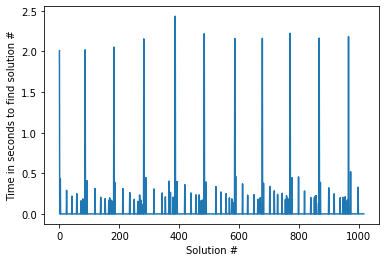

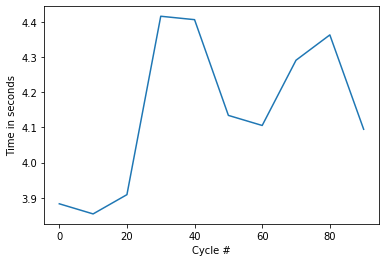

In [16]:
import random, time,os,codecs,sys
import queue as q
import numpy as np
import matplotlib.pyplot as plt
import threading
import subprocess

# class Node: #"nectar sources"
# 	def __init__(self,name):
# 		self.fitness = 0
# 		self.name = name

# class Edge:
# 	def __init__(self, x, y, weight):
# 		self.x = x
# 		self.y = y
# 		self.weight = weight
class SolutionFound(Exception):
	pass

def hdist(bits1,bits2):
	#print(len(bits1),len(bits2))
	assert(len(bits1) == len(bits2))
	count=0
	differing = []
	for a in range(len(bits1)):
		if(bits1[a] != bits2[a]): 
			count+=1
			differing.append(a)
	assert(len(differing) == count)
	return count, differing

def step_automata(state):
	next_state = ""
	for i in range(len(state)):
		L = state[(i-1) % len(state)]
		C = state[i]
		R = state[(i+1) % len(state)]
		if(L == "0" and C == "0" and R == "0") or (L == "1" and C == "1" and R == "1"):
			next_state+="0"
		else:
			next_state+="1"
	return next_state

def flip(val, r):
	if val[r] == "0":
		val = val[:r] +  "1" + val[r+1:]
	else:
		val = val[:r] +  "0" + val[r+1:]
	return val


class Bee:
	def __init__(self):
		self.type = ""
		self.source = None
		self.p = 0
		self.helped = True
		self.num_helped =0
		self.flip_two = False

	def print(self):
		print(self.type,self.source)

	def change(self):
		self.source = None
		self.type = "SCT"

		# if random.randint(0,3) == 0:
		# 	self.type = "ONL"
		# 	#print("Abandoning to scout")
		# else:
		# 	self.type = "SCT"
		# 	#print("Abandoning to observe")
	def calculate_p(self,colony):
		step = step_automata(self.source)
		hdist_val,_ = hdist(step,goal_bits)
		global best_p

		if hdist_val == 0:
			best_p = 0
			colony.return_vals.put((0,False,True,self))
			return

		elif hdist_val>(3*bit_len/4):
			self.change()
			colony.return_vals.put((0, False, False,self))
			return

		elif not self.helped:
			self.change()
			colony.return_vals.put((0, False, False,self))
			return
		else:
			#print("\n was helped last cycle by ",self.num_helped, "my p=",self.p)
			self.helped = False
			self.num_helped = 0
			self.p = 1/(hdist_val ** 2)

			if self.p > best_p:
				best_p = self.p
				#print("new_best = ",self.p, "cycle count = ",cycles)

			is_still_emp = self.improve_source()
			colony.return_vals.put((self.p, is_still_emp,False,self))
			return

	def improve_source(self):
		hdist_last, differing = hdist(step_automata(self.source),goal_bits)

		if hdist_last == 0:
			return True

		if hdist_last > 1:
			#Flip a few random bits 
			old = self.source
			for i in range(bit_len):
				new = self.source
				new = flip(new,i)

				#assert(hdist(self.source,new) == 1)
				if self.flip_two:
					r = random.randint(0,len(new)-1)
					new = flip(new,r)

				hdist_new,_ = hdist(step_automata(new),goal_bits) 
				if hdist_new <= hdist_last:
				#if hdist_new < hdist_last: FUNNY THING, THIS LINE RUNS WAY WAY WORSE THAN THE ABOVE ONE
					self.source = new
					hdist_last = hdist_new

				#if hdist_new < hdist_last:
					#self.flip_two = False
					#self.no_change = 0
					#print("better")

			if old == self.source:
				if self.flip_two:
					self.change()
					return False
				else:
					self.flip_two = True

				#self.no_change+=1 #only gets incremented if source is not improved despite flipping all bits

			return True
		else:
			#identify the differing bit
			#try to manually do it?	brute force?
			#print("hi I'm tryin ma best")		

			diff = differing[0]

			new = list(self.source)
			if goal_bits[diff] == 0:
				new[(diff-1) % bit_len] = "0"
				new[(diff) % bit_len] = "0"
				new[(diff) % bit_len] = "0"

				is_soln = step_automata(new) == goal_bits

				if not is_soln:
					new[(diff-1) % bit_len] = "1"
					new[(diff) % bit_len] = "1"
					new[(diff) % bit_len] = "1"

				#assert(hdist(self.source,new) == 3)

				self.source = "".join(new)
			else:
				pick = ["001","100","010","110","011","101"]
				choice = pick[random.randint(0,5)]

				#currently failing edge cases
				new[(diff-1) % bit_len] = choice[0]
				new[(diff) % bit_len] = choice[1]
				new[(diff) % bit_len] = choice[2]

				self.source = "".join(new)

				#self.source = flip(self.source,diff)

			#self.change()
			#return False
			return True



	def help(self):
		self.num_helped +=1
		if self.num_helped>=1 and not self.helped:
			self.helped = True
		self.improve_source()


COLONY_SIZE = 600			
class Colony:
	def __init__(self, solutions_found):

		sources = [random.randint(0,2**bit_len-1) for _ in range(COLONY_SIZE)]
		self.emp_bees = q.Queue()
		self.sct_bees = q.Queue()
		self.num_onl = 0
		self.solutions = solutions_found

		for i in range(COLONY_SIZE):
			new_bee = Bee()
			if i<COLONY_SIZE/2:
				bee_type = "EMP"
				src = "{0:b}".format(sources[i])
				new_bee.source = "0"*(bit_len-len(src)) + src
				new_bee.type = bee_type
				self.emp_bees.put(new_bee)
			elif i<COLONY_SIZE-1:
				self.num_onl+=1
			else:
				bee_type = "SCT"
				new_bee.type = bee_type
				self.sct_bees.put(new_bee)

	def print_bees(self):
		print("# EMP=",self.emp_bees.qsize()-self.scouted, "#ONL=",self.num_onl, "#SCT=",self.scouted, "TOTAL =",self.emp_bees.qsize()+self.num_onl)
		print("Kept job=",self.kept_emp, "Converted from onl to emp=",self.emp_bees.qsize()-self.kept_emp-self.scouted)

	def cycle(self):
		#Each worker attempts to impove the soltuion and calculates a p for itself
		prob_raw = []
		prob_bees = []
		new_emp_bees = q.Queue()

		delta = 0
		threads = []
		self.kept_emp = 0

		self.return_vals = q.Queue()
		while not self.emp_bees.empty():
			bee = self.emp_bees.get()
			t = threading.Thread(target=bee.calculate_p, args=[self])
			t.start()
			threads.append(t)

		for thread in threads:
			thread.join()


		while not self.return_vals.empty():
			p, is_still_emp, is_soln, bee = self.return_vals.get()
			if not is_soln:
				if is_still_emp:
					assert(bee.type == "EMP")
					prob_raw.append(p)
					prob_bees.append(bee)
					new_emp_bees.put(bee)
					self.kept_emp +=1
				else:
					delta+=1
					if bee.type == "SCT":
						self.sct_bees.put(bee)
					elif bee.type == "ONL":
						self.num_onl+=1
					else:
						bee.print()
						assert(False)
			else:
				#if solution found
				if bee.source not in self.solutions:
					assert(step_automata(bee.source) == goal_bits)

					global start,y
					now = time.time()
					y.append(now-start)
					start = now

					#print("solution!! Cycle # = ",cycles)
					self.solutions.append(bee.source)

					if not RANDOM_GOAL:
						#JUST FOR FUNSIES
						res = flag(bee.source)
						if res:
							print("FLAG FOUND")
							sys.exit(1)

				bee.source = None
				bee.type = "SCT"
				self.sct_bees.put(bee)

			#print("delta = ",delta/COLONY_SIZE)

		total = sum(prob_raw)
		prob = [p/total for p in prob_raw] #normalizes the probabilities

		#could possibly be 0 if there are no employed bees
		if len(prob_raw) > 0:
			assert(round(sum(prob)) == 1)

			#tell all onlooker bees to help
			for i in range(self.num_onl):
				choice = np.random.choice([i for i in range(len(prob))], p=prob)
				selected_bee = prob_bees[choice]
				selected_bee.help()


				# if random.randint(0,100) == 0:
				# 	bee = Bee()
				# 	bee.source = selected_bee.source
				# 	bee.type = "EMP"
				# 	new_emp_bees.put(bee)
				# 	self.num_onl-=1

		#give random sources to all scout bees
		self.scouted = 0
		while not self.sct_bees.empty():
			bee = self.sct_bees.get()
			src = "{0:b}".format(random.randint(0,(2**bit_len-1)))
			bee.source = "0"*(bit_len-len(src)) + src
			#print(bee.source)
			bee.type = "EMP"
			new_emp_bees.put(bee)
			self.scouted+=1

		self.emp_bees = new_emp_bees

		#assert that we haven't lost any bees
		if not (self.emp_bees.qsize() + self.num_onl + self.sct_bees.qsize() == COLONY_SIZE):
			self.print_bees()
			assert(False)

# graph = open("graph.txt").readlines()

# graph_edges = []
# graph_nodes = []
# for edge in graph:
# 	x,y,weight = edge.split(",")
# 	graph_edges.append(Edge(x,y,int(weight.strip())))

# 	node_names = [node.name for node in graph_nodes]

# 	if not x in node_names:
# 		node_x = Node(x)
# 		graph_nodes.append(node_x)

# 	if not y in node_names:
# 		node_y = Node(y)
# 		graph_nodes.append(node_y)

# print("nodes",[node.name for node in graph_nodes])
# print("edges",[(edge.x,edge.y, edge.weight) for edge in graph_edges])

RANDOM_GOAL = True

if RANDOM_GOAL:
	x = codecs.encode(os.urandom(8),'hex')
	x = x.decode('ascii')
	goal_bits = step_automata("{0:b}".format(int(x,16)))
else:
	goal = "66de3c1bf87fdfcf"
	goal_bits = "0"+"{0:b}".format(int(goal,16))
bit_len = len(goal_bits)
print("goal=",goal_bits, "len=",bit_len)
best_p = 0
c = Colony([])



desired_num_solns = 1000
start = time.time()
tic = start
y = []
cycles = 0
cycle_times = []
cycle_mod = 10

def flag(to_test):
	flag = "U2FsdGVkX18+Wl0awCH/gWgLGZC4NiCkrlpesuuX8E70tX8t/TAarSEHTnpY/C1D"
	as_int = int(to_test,2)
	hex_in = hex(as_int)
	res = subprocess.call(["./automata_dec.sh",hex_in])
	out = open("std_err.txt")
	a = out.readline()
	if a != "bad decrypt\n":
		#print("Maybe a flag?")
		try:	
			out = open("std_out.txt")
			print(out.readlines())
			return True
		except UnicodeDecodeError:
			#print("ignore")
			return False
			#pass
	return False

def activate_colony(c):
	#c.cycle()
	print("-"*20+"START"+"-"*20)
	last_p = 0
	last_soln_count = 0
	global cycles
	tec = time.time()
	while len(c.solutions) < desired_num_solns:#change this to < when the stuff is coded proper
		if cycles % cycle_mod == 0 and cycles>0:
			c.print_bees()
			toc = time.time()
			cycle_times.append(toc-tec)
			print("number of solutions found = ",len(c.solutions), "cycle time=",toc-tec,"current p = ",best_p,"\n")
			# if best_p == last_p and last_soln_count == len(c.solutions):
			# 	c = Colony(c.solutions)
			# 	print("resetting colony")
			# else:
			# 	last_p = best_p
			# 	last_soln_count = len(c.solutions)
			c = Colony(c.solutions) #Force reset every 10 cycles since each colony manages to find all the solutions it's ever going to find within 10 cycles
			tec = toc
		c.cycle()
		cycles+=1
		#break

#Sources are possible solutions
#Nectar is how good the given solution is 
activate_colony(c)

print("TOTAL TIME FOR", desired_num_solns, "SOLUTIONS = ",time.time()-tic, "FOR RANDOM_GOAL=",RANDOM_GOAL)
if len(cycle_times)>0:
	print("AVERAGE TIME FOR", cycle_mod,"CYCLES=", sum(cycle_times)/len(cycle_times))
else:
	print("LESS THAN", cycle_mod,"CYCLES TAKEN")
print("CYCLE COUNT=",cycles)
print("STD DEV in solution times=",np.std(y))

plt.plot(y)
plt.xlabel("Solution #")
plt.ylabel("Time in seconds to find solution #")
plt.show()

x = [cycle_mod*i for i in range(len(cycle_times))]
plt.plot(x,cycle_times)
plt.xlabel("Cycle #")
plt.ylabel("Time in seconds")
plt.show()